#Fine-Tune LLM 🦙


# Шаг 1: Установим все необходимые пакеты

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

#Шаг 2: Импортируем все необходимые библиотеки и подготовка датасета
[PEFT](https://huggingface.co/docs/peft/index) (Parameter-Efficient Fine-Tuning) - это основная библиотека для эффективного файн-тюна некоторого множества параметров предобученной языковой  модели.
В таблице, приведенной ниже, перечислены PEFT методы и модели, поддерживаемые для языкового моделирования.


| Model | LoRA | Prefix Tuning |P-Tuning | Prompt Tuning | IA3
|----------|----------|----------|-|-|-|
| GPT-2   | ✅ | ✅   | ✅|✅ |✅ |
| Bloom   |  ✅ |   ✅ |✅ | ✅| ✅|
| OPT   |   ✅ |✅   |✅ |✅ |✅ |
| GPT-Neo   |   ✅ |  ✅ |✅ |✅ | ✅|
| GPT-J   |   ✅ | ✅  |✅ | ✅|✅ |
| GPT-NeoX-20B   |  ✅  |  ✅ | ✅| ✅| ✅|
| LLaMA   |  ✅  | ✅  |✅ | ✅|✅ |
| ChatGLM   |   ✅ | ✅  | ✅| ✅| ✅|



**Мы будем рассматривать представителей ceмейства моделей LLaMA и адаптеров LoRA**

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

В случае для модели LLama 2  используется следующий шаблон промпта:
- Системный промпт (*опционально*) для руководства модели
- Пользовательский промпт (**обязательно**) для задания инструкции
- Ответ модели (**обязательно**)

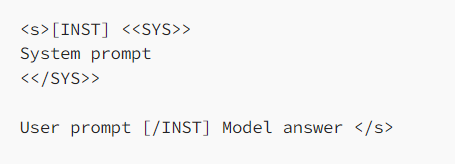

### Мы переформатируем набор наших данных в соответствии с шаблоном LLama 2.

Оригинальный датасет: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

Переформатированный набор данных в соответствии с шаблоном LLama 2 с выборкой в 1 тыс.: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

Полностью переформатированный набор данных в соответствии с шаблоном LLama 2: https://huggingface.co/datasets/mlabonne/guanaco-llama2

#### Это сделано в этом ноутбуке  https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

*Вам не нужно следовать определенному шаблону промппт, если вы используете базовую модель LLama 2, а не чатовую версию.*

#####**План тюна LLama 2**:



- Есть место только для хранения веса ламы 2–7b
- Нам также необходимо учитывать  расходы, связанные с состояниями оптимизатора, градиентами и активациями
- Полная тонкая настройка (файнтюн) здесь невозможна: нам нужны PEFT методы, такие как LoRA или QLoRa.
- Чтобы значительно сократить использование видеопамяти, мы должны сделать файнтюн с точностью до 4 бит, именно поэтому мы будем использовать здесь QLoRA.

#**Шаг 3: Загрузка модели и датасета**

1. Загрузим llama-2-7b-chat-hf модель (чатовая модель)
2. Обучим её на датасете mlabonne/guanaco-llama2-1k (1,000 samples), который подготовили ранее для файнтюна Llama-2-7b-chat-finetune

QLoRA будет использовать ранг 64 с параметром масштабирования 16. Мы загрузим модель Llama 2 непосредственно с точностью до 4 бит, используя тип NF4, и обучим ее в течение одной эпохи.

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Шаг 4: Загрузим все и начнем файнтюн**

1. Прежде всего, мы хотим загрузить набор данных, который мы определили. Здесь наш набор данных уже предварительно обработан, но, как правило, именно здесь вы переформатируете промпт, отфильтруете неверный текст, объедините несколько наборов данных и т.д.

2. Затем мы настраиваем bitsandbytes для 4-битного квантования.

3. Далее мы загружаем модель Llama 2 с точностью до 4 бит на графический процессор с соответствующим токенизатором.

4. Наконец, мы загружаем конфигурации для QLoRA, параметры обучения и передаем все в SFTTrainer. Наконец-то тренировка может начаться!

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,1.408600
50,1.657900
75,1.213600
100,1.443500
125,1.177400
150,1.365200


##**Шаг 5: Проверим графики tensorboard**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

#Шаг 6: Используем пайплайн генерации текста, чтобы задавать вопросы
**Обратите внимание, что я форматирую ввод в соответствии с шаблоном промпта Llama 2.**

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

Вы можете обучить модель Llama 2 на всем наборе данных, используя [mlabonne/guanaco-llama2](https://huggingface.co/datasets/mlabonne/guanaco-llama2)

#**Шаг 7: Сохраним новую модель Llama 2(Llama-2-7b-chat-finetune)**

Как мы можем сохранить нашу новую модель Llama-2-7b-chat-finetune прямо сейчас? Нам нужно объединить веса из LoRa с базовой моделью. К сожалению, насколько я знаю, простого способа сделать это не существует: нам нужно перезагрузить базовую модель в FP16 precision и использовать библиотеку peft для объединения всего.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#**Шаг 8: Запушим модель на Hugging Face Hub**

Наши веса объединены, и мы перезагрузили токенизатор. Теперь мы можем перенести все в Hugging Face Hub, чтобы сохранить нашу модель.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
your_nick = 'awesomeboy'

In [ ]:
!huggingface-cli login

model.push_to_hub(f"{your_nick}/Llama-2-7b-chat-finetune", check_pr=True)

tokenizer.push_to_hub(f"{your_nick}/Llama-2-7b-chat-finetune",check_pr=True)


Теперь вы можете использовать эту модель, загрузив ее, как и любую другую модель Llama 2, из HF.